# Actividad 3, Desarrollo
Felix Armando Acosta Ledesma A01242337

In [1]:
#Librerias para la actividad
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [16]:
#En esta sección ser cargan las imágenes a color de emojis. Las imágenes
#se orginizan en 5 directorios, los cuales son: Angry, Happy, Poo, Sad y Surprise.
#Los nombres de las imágenes no están estandarizadas, por lo que es necesario primero ver qué hay
#en cada directorio y después cargarlas.
path = 'C:/hc_semana_tec/Emojis/'

emojis = []
labels = ['Angry', 'Happy', 'Poo', 'Sad', 'Surprised']
for label in labels:
    folder = os.path.join(path, label)
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                emojis.append((img, label))

print("Número total de imágenes cargadas:", len(emojis)) 

Número total de imágenes cargadas: 2530


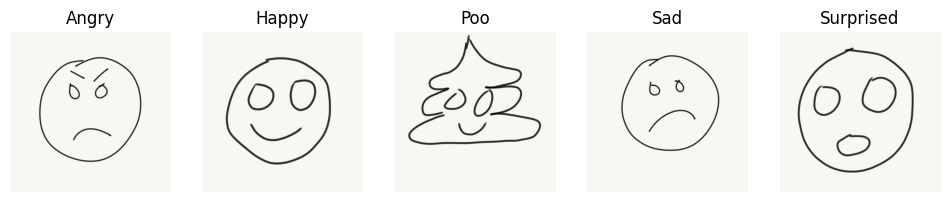

In [17]:
#Muestra una imagen de cada categoría
plt.figure(figsize=(12, 8))
for i, label in enumerate(labels):
    for img, img_label in emojis:
        if img_label == label:
            plt.subplot(1, 5, i + 1)
            plt.imshow(img)
            plt.title(label)
            plt.axis('off')
            break

In [18]:
# Preprocesamiento de las imágenes. Las imágenes las vamos a pasar a escala de grises, a un 
# tamaño de 32x32 píxeles. Desafortunadamente, los trazos no están centrados en la imagen, por lo que
# también es necesario encontrar la zona del trazo, y recortarlo para después centrarlo en la imagen.

def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Imagen binaria (fondo blanco, trazos negros)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        min_area = 30
        all_points = np.vstack([cnt for cnt in contours if cv2.contourArea(cnt) > min_area])
        x, y, w, h = cv2.boundingRect(all_points)
        roi = binary[y:y+h, x:x+w]  # Usar la imagen binaria
        roi_resized = cv2.resize(roi, (32, 32), interpolation=cv2.INTER_AREA)
        padded = np.pad(roi_resized, ((2, 2), (2, 2)), mode='constant', constant_values=0)
        return padded
    else:
        return cv2.resize(binary, (32, 32), interpolation=cv2.INTER_AREA)

preprocessed_emojis = [(preprocess_image(img), label) for img, label in emojis]
print("Número total de imágenes preprocesadas:", len(preprocessed_emojis))

Número total de imágenes preprocesadas: 2530


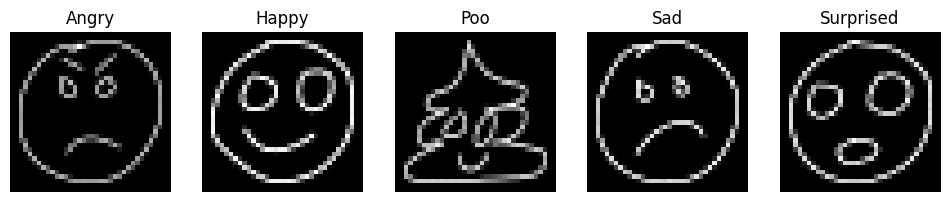

In [19]:
# Muestra una imagen de cada categoría preprocesada
plt.figure(figsize=(12, 8))
for i, label in enumerate(labels):
    for img, img_label in preprocessed_emojis:
        if img_label == label:
            plt.subplot(1, 5, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(label)
            plt.axis('off')
            break

In [20]:
# Ajuste y evaluación de un modelo MLP mejorado con normalización y Dropout
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Preparar datos
X = np.array([img for img, label in preprocessed_emojis])
X = X.reshape((X.shape[0], -1))  # Aplanar imágenes
X = X.astype('float32') / 255.0  # Normalizar a [0,1]
label_to_idx = {label: idx for idx, label in enumerate(labels)}
y = np.array([label_to_idx[label] for _, label in preprocessed_emojis])
y_cat = to_categorical(y, num_classes=len(labels))

# Separar en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)

# Definir modelo MLP mejorado
mlp = Sequential([
    Dense(256, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(labels), activation='softmax')
])
mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar
history = mlp.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# Evaluar
loss, acc = mlp.evaluate(X_test, y_test, verbose=0)
print(f"\nPrecisión en test: {acc:.3f}")

# Reporte de clasificación
y_pred = np.argmax(mlp.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print("\nReporte de clasificación:\n", classification_report(y_true, y_pred, target_names=labels))

Epoch 1/50


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4624 - loss: 1.1719 - val_accuracy: 0.6453 - val_loss: 1.0018
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4624 - loss: 1.1719 - val_accuracy: 0.6453 - val_loss: 1.0018
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6645 - loss: 0.8374 - val_accuracy: 0.7438 - val_loss: 0.7038
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6645 - loss: 0.8374 - val_accuracy: 0.7438 - val_loss: 0.7038
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7814 - loss: 0.5891 - val_accuracy: 0.8030 - val_loss: 0.6138
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7814 - loss: 0.5891 - val_accuracy: 0.8030 - val_loss: 0.6138
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8248 - loss: 0.4540 - val_accuracy: 0.7882 - val_loss: 0.6013
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8248 - loss: 0.4540 - val_accuracy: 0.7882 - val_

In [21]:
# Ajuste y evaluación de una CNN para las imágenes binarias
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Preparar datos para CNN
X = np.array([img for img, label in preprocessed_emojis])
X = X.astype('float32') / 255.0  # Normalizar
X = X[..., np.newaxis]  # Añadir canal para CNN (shape: N, 36, 36, 1)
label_to_idx = {label: idx for idx, label in enumerate(labels)}
y = np.array([label_to_idx[label] for _, label in preprocessed_emojis])
y_cat = to_categorical(y, num_classes=len(labels))

# Separar en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)

# Definir modelo CNN
cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(X.shape[1], X.shape[2], 1)),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(labels), activation='softmax')
])
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar
history_cnn = cnn.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1, verbose=1)

# Evaluar
loss, acc = cnn.evaluate(X_test, y_test, verbose=0)
print(f"\nPrecisión en test (CNN): {acc:.3f}")

# Reporte de clasificación
y_pred = np.argmax(cnn.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print("\nReporte de clasificación (CNN):\n", classification_report(y_true, y_pred, target_names=labels))

Epoch 1/30


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5739 - loss: 1.0386 - val_accuracy: 0.7931 - val_loss: 0.5780
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5739 - loss: 1.0386 - val_accuracy: 0.7931 - val_loss: 0.5780
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7913 - loss: 0.5409 - val_accuracy: 0.8473 - val_loss: 0.4291
Epoch 3/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7913 - loss: 0.5409 - val_accuracy: 0.8473 - val_loss: 0.4291
Epoch 3/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8347 - loss: 0.4046 - val_accuracy: 0.8571 - val_loss: 0.3475
Epoch 4/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8347 - loss: 0.4046 - val_accuracy: 0.8571 - val_loss: 0.3475
Epoch 4/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8677 - loss: 0.3228 - val_accuracy: 0.9015 - val_loss: 0.2524
Epoch 5/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8677 - loss: 0.3228 - val_accuracy: 0.901